In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.distributions import Normal
from scipy.linalg import block_diag
from numpy.linalg import inv
from numpy.linalg import det
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import numpy.matlib as nm
import matplotlib.patches as mpatches
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
def get_lstm_params(num_inputs, num_hiddens, num_outputs, num_units):
    
    def normal(shape):
        return Variable(nn.Parameter(torch.randn(size = shape))) * 0.01
    def zero(shape):
        return Variable(nn.Parameter(torch.zeros(shape)))
    def three(num_inputs, num_hiddens, num_outputs):
        return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), zero(num_hiddens))
    
    W_xi, W_hi, b_i = three(num_inputs, num_hiddens, num_outputs) # 输入门参数
    W_xf, W_hf, b_f = three(num_inputs, num_hiddens, num_outputs) # 遗忘门参数
    W_xo, W_ho, b_o = three(num_inputs, num_hiddens, num_outputs) # 输出门参数
    W_xc, W_hc, b_c = three(num_inputs, num_hiddens, num_outputs) # 候选记忆门参数
    
    # 输出层参数
    W_hq = normal((num_units, num_hiddens, num_outputs))
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq]
    for param in params:
        param.requires_grad_(True)
    
    return params 

In [3]:
def init_lstm_state(batch_size, num_hiddens):
    return (torch.ones(batch_size, num_hiddens)*(-20.0), 
            torch.ones(batch_size, num_hiddens)*(-20.0))

In [4]:
def lstm(inputs, state, unit_index, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    W_hq = params[12][unit_index]
    (H, C) = state
    
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        Y = H @ W_hq
        outputs.append(Y)

    return torch.cat(outputs, dim = 0)

In [5]:
class RNNModelScratch():
    def __init__(self, num_inputs, num_hiddens, num_outputs, 
                 num_units, get_params, init_state, forward_fn):   
        self.num_inputs, self.num_hiddens = num_inputs, num_hiddens
        self.num_outputs, self.num_units = num_outputs, num_units
        self.params = get_params(num_inputs, num_hiddens, num_outputs, num_units)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state, unit_index):
        return self.forward_fn(X, state, unit_index, self.params)
    
    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [6]:
class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2  # 转化为距离矩阵
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, historical_grad, lnprob, n_iter, stepsize, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        # historical_grad = 0
        # for iter in range(n_iter):
        #    if debug and (iter+1) % 1000 == 0:
        #        print('iter ' + str(iter+1))
            
        lnpgrad = lnprob(theta)
        # calculating the kernel matrix
        kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
        grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  

        # adagrad 
        if n_iter == 0:
            historical_grad = historical_grad + grad_theta ** 2
        historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
        
        adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
        # theta = theta + stepsize * adj_grad 
            
        return adj_grad, historical_grad

In [7]:
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A # 协方差的逆矩阵
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)

In [8]:
def train(net, lr, num_epochs, inputs, targets, batch_size, model, step_size):
    loss = nn.MSELoss()
    updater = optim.Adam(net.params, lr)
    num_unit = len(X)
    
    historical_grad = 0
    loss_lt = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        L = torch.zeros(num_unit)      
        for i in range(num_unit):
            state = net.begin_state(batch_size)
            y_preb = net(inputs[i], state, i)
            L[i] = loss(y_preb, targets[i])
        
        tmp_gamma = net.params[12].detach().permute(0,2,1).numpy().reshape(num_unit, -1)
        grad, historical_grad = SVGD().update(tmp_gamma, historical_grad, model.dlnprob, epoch, step_size)
        
        loss_lt[epoch] = L.mean().item()
        updater.zero_grad()
        L.mean().backward()
        updater.step()
        
        net.params[12].data += step_size * torch.tensor(grad.reshape(num_unit,3,6), dtype=torch.float)
        # net.params[12] = torch.tensor(net.params[12].detach().numpy(), dtype=torch.float, requires_grad=True)
        
        if epoch % 10 == 0:
            print('epoch:{}/{}'.format(epoch+1, num_epochs))
            print('Loss:', L.mean().item())

    print('finished training!')

    return loss_lt

In [9]:
# A = np.diag(np.ones(18))
# mu = np.zeros(18)

A = np.load('cov1.npy')
mu = np.load('mu1.npy').reshape(-1)

model = MVN(mu, A)

In [10]:
#  读入训练数据
df_train = pd.read_csv('train_data.csv')
num_units = df_train['Unit'].max()
num_train = 20
num_sensors = 6

np.random.seed(111)
selected_unit = np.random.choice(num_units, num_units, replace=False)

T = [torch.tensor([i/500.0]) for i in range(500)]
X = []
train_data = []
lengths = []

for i in selected_unit[:num_train]:
    sensor_data = torch.tensor(df_train[df_train['Unit'] == i+1].iloc[:,2:].values, dtype = torch.float)  
    X.append(T[:sensor_data.shape[0]])
    train_data.append(sensor_data)
    lengths.append(len(sensor_data)) 

val_data = []
val_lengths = []
for i in selected_unit[num_train:]:
    sensor_data = df_train[df_train['Unit'] == i+1].iloc[:,2:].values  
    val_data.append(sensor_data)
    val_lengths.append(len(sensor_data)) 

In [11]:
num_inputs = 1
num_hiddens = 3
num_outputs = 6
net = RNNModelScratch(num_inputs, num_hiddens, num_outputs, num_train, get_lstm_params, init_lstm_state, lstm)
net.params = torch.load('LSTM-SVGD(20)-1.pth')

In [12]:
def get_H(inputs, params, num_hiddens):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    (H, C) = init_lstm_state(1, num_hiddens)
    H_lt = torch.zeros((len(inputs), num_hiddens))
    for i in range(len(inputs)):
        X = inputs[i]
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        
        H_lt[i] = H
    
    return H_lt

def predict_sensors(targets, unit_index, valid_len): 
    fig = plt.figure(figsize=(12,4))
    tmp_Psi = Psi[:valid_len]
    y_pred = tmp_Psi @ gamma[unit_index].T
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        t1 = np.arange(len(targets))
        t2 = np.arange(len(tmp_Psi))
        plt.plot(t1[8:], targets[8:,i], '.', markersize=3)
        plt.plot(t2[8:], y_pred[8:,i], color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

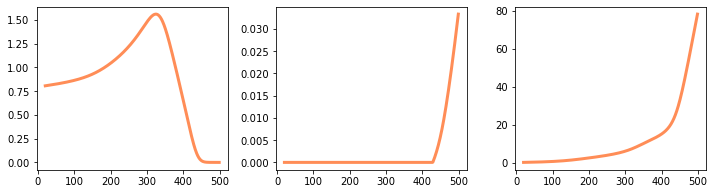

In [13]:
# num_train = 20
Psi = get_H(T, net.params, num_hiddens).detach().numpy()

tmp_gamma = net.params[12].detach().numpy()
gamma = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    gamma[i] = tmp_gamma[i].T
    
fig = plt.figure(figsize=(12,3))

for i in range(3):
    plt.subplot(1, 3, 1+i)
    t = np.arange(Psi.shape[0])
    plt.plot(t[20:], Psi[20:,i], color='#FF8D57', linewidth = 3)

plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
plt.show()

In [14]:
def plot_distribution(sensor_index):
    x1 = gamma[:,sensor_index,0]
    y1 = gamma[:,sensor_index,2]
    data = np.hstack((x1.reshape(-1,1),y1.reshape(-1,1)))
    mu0, cov0 = data.mean(axis=0), np.cov(data.T)

    val_gamma = np.zeros((80,2))
    for i in range(80):
        L_i = val_data[i][:,sensor_index]
        tmp_psi = np.delete(Psi, 1, 1)[:val_lengths[i]]
        gamma_i = inv(tmp_psi.T @ tmp_psi) @ tmp_psi.T @ L_i
        val_gamma[i] = gamma_i
        
    x2 = val_gamma[:,0]
    y2 = val_gamma[:,1]

    lambda_, v = np.linalg.eig(cov0)    # 计算特征值lambda_和特征向量v
    sqrt_lambda = np.sqrt(np.abs(lambda_))    # 存在负的特征值， 无法开方，取绝对值

    s = 2.5
    width = 2 * np.sqrt(s) * sqrt_lambda[0]    # 计算椭圆的两倍长轴
    height = 2 * np.sqrt(s) * sqrt_lambda[1]   # 计算椭圆的两倍短轴
    angle = np.rad2deg(np.arccos(v[0, 0]))    # 计算椭圆的旋转角度
    
    return (x1,y1),(x2,y2),mu0,width,height,angle

def KL(mu1, mu2, cov1, cov2):
    kl1 = np.log(det(cov2)/det(cov1))
    kl2 = np.trace(inv(cov2)@cov1)
    kl3 = (mu1-mu2).T @ inv(cov2) @ (mu1-mu2)
    d = len(mu1)
    
    return 0.5*(kl1 - d + kl2 + kl3)

In [15]:
for i in range(6):
    x1 = gamma[:,i,0]
    y1 = gamma[:,i,2]
    data0 = np.hstack((x1.reshape(-1,1),y1.reshape(-1,1)))
    mu0, cov0 = data0.mean(axis=0), np.cov(data0.T)
    
    val_gamma = np.zeros((80,2))
    for j in range(80):
        L_j = val_data[j][:,i]
        tmp_psi = np.delete(Psi, 1, 1)[:val_lengths[j]]
        gamma_j = inv(tmp_psi.T @ tmp_psi) @ tmp_psi.T @ L_j
        val_gamma[j] = gamma_j
        
    data = np.vstack((data0,val_gamma))
    mu, cov = data.mean(axis=0), np.cov(data.T)

    print("%.4f"%KL(mu0, mu, cov0, cov))

0.2031
0.1455
0.3027
0.2216
0.0992
0.1459


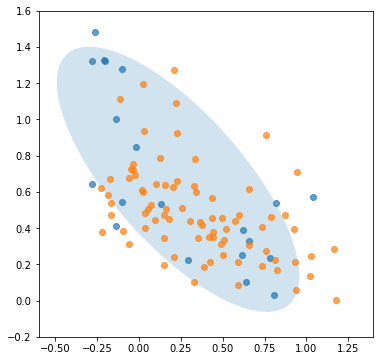

In [16]:
sensor_index = 2
(x1,y1),(x2,y2),mu0,width,height,angle = plot_distribution(sensor_index)


plt.figure(figsize=(6,6))
ax = plt.axes()

plt.plot(x1,y1,'o',alpha=0.7)
plt.plot(x2,y2,'o',alpha=0.7)

ellipse = mpatches.Ellipse(xy=mu0, width=width, height=height, angle=-angle)    # 绘制椭圆
ax.add_artist(ellipse)  
ellipse.set_alpha(alpha=0.2)

# plt.scatter(x,y,color='#B0DEC3')

#ax.set_xticks([])
#ax.set_yticks([])

ax.set_xlim(-0.6,1.4)
ax.set_ylim(-0.2,1.6)

# plt.savefig('distribution with SVGD-2', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

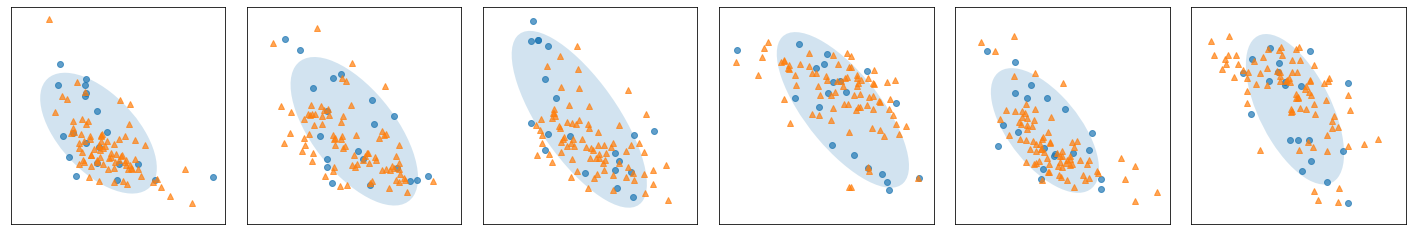

In [21]:
fig, axes = plt.subplots(1,6,figsize=(25,4))  # 此处是一个2*2的图

"""绘制传感器一"""
ax1 = plt.subplot(161)
(x1,y1),(x2,y2),mu0,width,height,angle = plot_distribution(0)

plt.plot(x1,y1,'o',alpha=0.7)
plt.plot(x2,y2,'^',alpha=0.7)

ellipse = mpatches.Ellipse(xy=mu0, width=width, height=height, angle=-angle)    # 绘制椭圆
ax1.add_artist(ellipse)  
ellipse.set_alpha(alpha=0.2)

ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_xlim(-0.4,2.3)
ax1.set_ylim(-0.3,1.4)


"""绘制传感器二"""
ax2 = plt.subplot(162)
(x1,y1),(x2,y2),mu0,width,height,angle = plot_distribution(1)

plt.plot(x1,y1,'o',alpha=0.7)
plt.plot(x2,y2,'^',alpha=0.7)

ellipse = mpatches.Ellipse(xy=mu0, width=width, height=height, angle=-angle)    # 绘制椭圆
ax2.add_artist(ellipse)  
ellipse.set_alpha(alpha=0.2)

ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_xlim(-0.6,1.6)
ax2.set_ylim(-0.2,1.5)

"""绘制传感器三"""
ax3 = plt.subplot(163)
(x1,y1),(x2,y2),mu0,width,height,angle = plot_distribution(2)

plt.plot(x1,y1,'o',alpha=0.7)
plt.plot(x2,y2,'^',alpha=0.7)

ellipse = mpatches.Ellipse(xy=mu0, width=width, height=height, angle=-angle)    # 绘制椭圆
ax3.add_artist(ellipse)  
ellipse.set_alpha(alpha=0.2)

ax3.set_xticks([])
ax3.set_yticks([])

ax3.set_xlim(-0.8,1.5)
ax3.set_ylim(-0.2,1.6)

"""绘制传感器四"""
ax4 = plt.subplot(164)
(x1,y1),(x2,y2),mu0,width,height,angle = plot_distribution(3)

plt.plot(x1,y1,'o',alpha=0.7)
plt.plot(x2,y2,'^',alpha=0.7)

ellipse = mpatches.Ellipse(xy=mu0, width=width, height=height, angle=-angle)    # 绘制椭圆
ax4.add_artist(ellipse)  
ellipse.set_alpha(alpha=0.2)

ax4.set_xticks([])
ax4.set_yticks([])

ax4.set_xlim(-1.6,0.5)
ax4.set_ylim(-1.6,0.3)

"""绘制传感器五"""
ax5 = plt.subplot(165)
(x1,y1),(x2,y2),mu0,width,height,angle = plot_distribution(4)

plt.plot(x1,y1,'o',alpha=0.7)
plt.plot(x2,y2,'^',alpha=0.7)

ellipse = mpatches.Ellipse(xy=mu0, width=width, height=height, angle=-angle)    # 绘制椭圆
ax5.add_artist(ellipse)  
ellipse.set_alpha(alpha=0.2)

ax5.set_xticks([])
ax5.set_yticks([])

ax5.set_xlim(-0.5,2.1)
ax5.set_ylim(-0.3,1.5)

"""绘制传感器六"""
ax6 = plt.subplot(166)
(x1,y1),(x2,y2),mu0,width,height,angle = plot_distribution(5)

plt.plot(x1,y1,'o',alpha=0.7)
plt.plot(x2,y2,'^',alpha=0.7)

ellipse = mpatches.Ellipse(xy=mu0, width=width, height=height, angle=-angle)    # 绘制椭圆
ax6.add_artist(ellipse)  
ellipse.set_alpha(alpha=0.2)

ax6.set_xticks([])
ax6.set_yticks([])

ax6.set_xlim(-1.6,0.4)
ax6.set_ylim(-1.2,0.2)

plt.subplots_adjust(wspace = 0.1, hspace = 0.35)
plt.savefig('distribution with SVGD-6-s', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

In [18]:
# 计算传感器噪声方差
sigma2 = np.zeros(num_sensors)

for i in range(num_sensors):
    tmp_sigma2 = 0
    tmp_m = 0
    for j in range(num_train):
        gamma_j = gamma[j,i]
        sensor_data = train_data[j][:,i].detach().numpy()
        tmp_n = lengths[j]
        
        tmp_Psi = Psi[:tmp_n]
        sensor_path = tmp_Psi @ gamma_j
        
        tmp_sigma2 += np.power(sensor_path - sensor_data, 2).sum()
        tmp_m += (tmp_n - 6)
        
    sigma2[i] = tmp_sigma2/tmp_m
sigma2

array([0.09367524, 0.06543641, 0.06773338, 0.06035353, 0.09372196,
       0.08276461])

In [19]:
# gamma的均值和协方差
cov_list = []
for i in range(num_sensors):
    data_i = gamma[:,i]
    cov_i = np.cov(data_i.T)
    cov_list.append(cov_i)
    
cov = block_diag(cov_list[0],cov_list[1],cov_list[2],cov_list[3],cov_list[4],cov_list[5])
# cov = np.cov(gamma.reshape(num_train,-1).T)
mu = gamma.reshape(num_train,-1).mean(axis=0).reshape(-1,1)

cov.shape, mu.shape

((18, 18), (18, 1))

In [20]:
mu[:3]

array([[ 0.70462624],
       [-0.00084667],
       [ 0.41255976]])

In [21]:
cov[:3,:3]

array([[ 2.15371258e-01,  1.53835313e-03, -7.99378038e-02],
       [ 1.53835313e-03,  9.16943615e-05, -1.14834807e-03],
       [-7.99378038e-02, -1.14834807e-03,  8.91933507e-02]])

In [41]:
mu0 = np.array([0.70462624,0.41255976])
cov0 = np.array([2.15371258e-01,-7.99378038e-02,-7.99378038e-02,8.91933507e-02]).reshape(2,2)

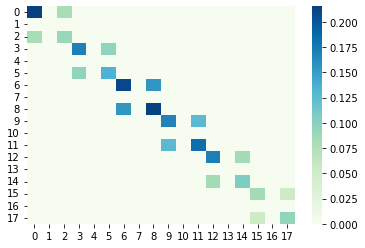

In [17]:
sns.heatmap(abs(cov), cmap='GnBu')
# plt.savefig('approximate cov_matrix.png', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

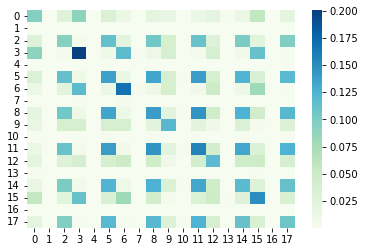

In [36]:
cov = np.cov(gamma.reshape(num_train,-1).T)
sns.heatmap(abs(cov), cmap='GnBu')
# plt.savefig('true cov_matrix.png', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

In [84]:
# num_train = 100

mu_i = np.zeros((num_train, 3*num_sensors,1)) 
cov_i = np.zeros((num_train,3*num_sensors,3*num_sensors))

for i in range(num_train):
    tmp_n = lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = train_data[i].detach().numpy().T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_i[i] = tmp_mu
    cov_i[i] = tmp_cov

In [85]:
# 设置特征值-logistic regression
N, delta, K = 80, 1, 25 # 超参数
inputs = np.zeros((K*num_train,2*N,num_sensors))

for i in range(num_train):
    M = lengths[i]
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)  
    
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
        
    for k in range(K):
        inputs[i*K+k] = (Psi @ gamma_samples[k].reshape(num_sensors,-1).T)[t]
        
# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
# print(label.shape) (1,160)
labels = np.repeat(labels, K*num_train, axis=0)

inputs.shape, labels.shape

((500, 160, 6), (500, 160))

In [86]:
from sklearn.linear_model import LogisticRegression
X_train = inputs.reshape(-1,num_sensors)
Y_train = labels.reshape(-1,1)
X_train.shape, Y_train.shape

model2 = LogisticRegression(penalty="l2", C=0.01, solver="sag", max_iter=1000) #创建模型
model2.fit(X_train, Y_train.ravel()) #训练

LogisticRegression(C=0.01, max_iter=1000, solver='sag')

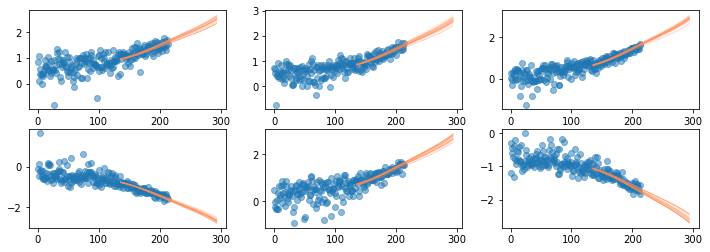

In [191]:
index = 10
sensor_data = train_data[index]

M = lengths[index]
t = torch.zeros(2*N, dtype=torch.long)
for j in range(2*N):
    t[j] = M + (j-N+1) * delta

fig = plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha=0.5)
    for k in range(K):
        sensor_path = inputs[index*K + k]
        plt.plot(t, sensor_path[:,i], color='#FF8D57', linewidth = 0.2)

In [87]:
df_test = pd.read_csv('test_data.csv')
num_test = df_test['Unit'].max()      # 测试数据数量

test_data = []
test_lengths = []
for i in range(num_test):
    Y = np.array(df_test[df_test['Unit']==i+1].iloc[:,2:]) 
    test_data.append(Y)
    test_lengths.append(len(Y))
    
mu_j = np.zeros((num_test, num_hiddens*num_sensors,1)) 
cov_j = np.zeros((num_test,num_hiddens*num_sensors,num_hiddens*num_sensors))

for i in range(num_test):
    tmp_n = test_lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = test_data[i].T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_j[i] = tmp_mu
    cov_j[i] = tmp_cov

mu_j.shape, cov_j.shape

((100, 18, 1), (100, 18, 18))

In [175]:
np.save('test_mu_svgd.npy',mu_j)
np.save('test_cov_svgd.npy',cov_j)

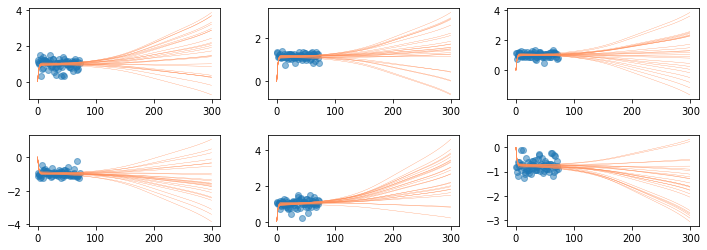

In [193]:
index, K, valid_len = 46, 25, 300
sensor_data = test_data[index]
tmp_Psi = Psi[:valid_len]
gamma_samples = np.random.multivariate_normal(mu_j[index].flatten(), cov_j[index], size=K)

fig = plt.figure(figsize=(12,4))

for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha = 0.5)
    for k in range(K):
        sensor_path = tmp_Psi @ gamma_samples[k].reshape(num_sensors,-1).T
        plt.plot(sensor_path[:,i], color='#FF8D57', linewidth=0.3)
        
plt.subplots_adjust(wspace = 0.25, hspace = 0.4)
plt.show()

In [57]:
def RMSE(true_RUL, pred_RUL):
    d = true_RUL - pred_RUL
    return np.sqrt(np.power(d,2).mean())

def score(true_RUL, pred_RUL):
    d = pred_RUL - true_RUL
    n = len(true_RUL)
    score = np.zeros(n)
    for i in range(n):
        d_i = d[i]
        if d_i >= 0:
            score[i] = np.exp(d_i/10) - 1
        elif d_i < 0:
            score[i] = np.exp(-d_i/13) - 1
    return score.sum()

In [88]:
results1 = np.zeros(50)
results2 = np.zeros(50)
results3 = np.zeros(50)

for l in range(50):
    # 设置特征值
    K = 100 # 超参数
    X_test = np.zeros((num_test, K, Psi.shape[0], num_sensors))
    for i in range(num_test):
        gamma_samples = np.random.multivariate_normal(mu_j[i].flatten(), cov_j[i], size=K)    
        for k in range(K):
            X_test[i,k] = Psi @ gamma_samples[k].reshape(num_sensors,-1).T
            
    pred_RUL = np.zeros(num_test)

    for i in range(num_test):
        
        p = np.zeros((K, Psi.shape[0]))
        for k in range(K):
            x_i = X_test[i,k]
            p[k] = model2.predict_proba(x_i)[:,1]
        pp = p.mean(axis=0)
        tmp_n = test_lengths[i]
        p_T = (pp - pp[tmp_n])/(1 - pp[tmp_n])
        pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_n
        
    df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
    df_RUL['pred_RUL'] = pred_RUL
    df_RUL['lifetime'] = df_RUL['true_RUL'] + test_lengths
    df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
    results1[l] = df_RUL['error'].mean()
    results2[l] = RMSE(df_RUL['true_RUL'], df_RUL['pred_RUL'])
    results3[l] = score(df_RUL['true_RUL'], df_RUL['pred_RUL'])

In [89]:
results1.mean(), results1.std()

(0.06318547498957322, 0.0006231603029654831)

In [75]:
results2.mean(), results2.std()

(16.809717400924665, 0.15231841993151812)

In [76]:
results3.mean(), results3.std()

(722.416397793025, 37.58843647718607)

In [36]:
results3.min()

606.5519077837605

In [45]:
results3[results3 < 5000].mean(), results3[results3 < 5000].std()

(673.8194785944451, 32.82212084983398)

In [57]:
K = 25 # 超参数
X_test = np.zeros((num_test, K, Psi.shape[0], num_sensors))
for i in range(num_test):
    gamma_samples = np.random.multivariate_normal(mu_j[i].flatten(), cov_j[i], size=K)    
    for k in range(K):
        X_test[i,k] = Psi @ gamma_samples[k].reshape(num_sensors,-1).T

pred_RUL = np.zeros(num_test)

for i in range(num_test):

    p = np.zeros((K, Psi.shape[0]))
    for k in range(K):
        x_i = X_test[i,k]
        p[k] = model.predict_proba(x_i)[:,1]
    pp = p.mean(axis=0)
    tmp_n = test_lengths[i]
    p_T = (pp - pp[tmp_n])/(1 - pp[tmp_n])
    pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_n

df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
df_RUL['pred_RUL'] = pred_RUL
df_RUL['lifetime'] = df_RUL['true_RUL'] + test_lengths
df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
df_RUL['error'].mean()

0.07332542352308459

In [45]:
def RMSE(true_RUL, pred_RUL):
    d = true_RUL - pred_RUL
    return np.sqrt(np.power(d,2).mean())

In [58]:
RMSE(df_RUL['true_RUL'], df_RUL['pred_RUL'])

20.38872237291979

In [78]:
df_RUL.to_excel('Result.xlsx')

In [ ]:
# 设置特征值-logistic regression
N, delta, K = 80, 1, 50 # 超参数

# 设置特征值-logistic regression
N, delta, K = 80, 1, 10 # 超参数
inputs = np.zeros((num_train,2*N,num_sensors))

for i in range(20):
    M = lengths[i]
    y_pred = Psi @ gamma[i].T
        
    M = lengths[i]
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
    
    inputs[i] = y_pred[t]
    
for i in range(20, num_train):
    M = lengths[i]
    y_pred = np.zeros((K,2*N,num_sensors))
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)  
        
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
        
    for k in range(K):
        y_pred[k] = (Psi @ gamma_samples[k].reshape(num_sensors,-1).T)[t]
    
    inputs[i] = y_pred.mean(axis=0)

# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
labels = np.repeat(labels, num_train, axis=0)

np.save('inputs-svgd.npy', inputs)
np.save('labels-svgd.npy',labels)

inputs.shape, labels.shape